In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
from datetime import datetime
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings("ignore") 

In [75]:
df_customer = pd.read_csv("Customers.csv")
df_customer.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [76]:
df_transaction = pd.read_csv("Transactions.csv")
df_transaction.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [77]:
df_customer['SignupDate'] = pd.to_datetime(df_customer['SignupDate'])
df_transaction['TransactionDate'] = pd.to_datetime(df_transaction['TransactionDate'])

In [78]:
customer_transactions = df_transaction.groupby('CustomerID').agg({
    #'TransactionID': 'count',  
    'TotalValue': 'sum',       
    'TransactionDate': 'max'    
}).reset_index()
customer_transactions.head()

,CustomerID,TotalValue,TransactionDate
0,C0001,3354.52,2024-11-02 17:04:16
1,C0002,1862.74,2024-12-03 01:41:41
2,C0003,2725.38,2024-08-24 18:54:04
3,C0004,5354.88,2024-12-23 14:13:52
4,C0005,2034.24,2024-11-04 00:30:22


## Customer Transaction Aggregation

In this step, we aggregate customer transaction data by grouping it based on `CustomerID`. For each customer, we calculate:

- **TotalValue**: The sum of all transaction values.
- **Quantity**: The total quantity of items purchased.
- **TransactionDate**: The most recent transaction date.

The **TransactionID count** was excluded as it was not contributing significantly to the analysis and was reducing the quality of the results.


In [79]:
customer_transactions.rename(columns={
    #'TransactionID': 'PurchaseFrequency',
    'TotalValue': 'TotalSpend',
    'TransactionDate': 'LastPurchaseDate'
}, inplace=True)
customer_transactions.head()

,CustomerID,TotalSpend,LastPurchaseDate
0,C0001,3354.52,2024-11-02 17:04:16
1,C0002,1862.74,2024-12-03 01:41:41
2,C0003,2725.38,2024-08-24 18:54:04
3,C0004,5354.88,2024-12-23 14:13:52
4,C0005,2034.24,2024-11-04 00:30:22


In [80]:
# Merge customer profiles and transaction aggregates
data = pd.merge(df_customer, customer_transactions, on='CustomerID', how='left')

In [81]:
data.head()

,CustomerID,CustomerName,Region,SignupDate,TotalSpend,LastPurchaseDate
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,2024-11-02 17:04:16
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,2024-12-03 01:41:41
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,2024-08-24 18:54:04
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,2024-12-23 14:13:52
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,2024-11-04 00:30:22


In [82]:
data.fillna({'PurchaseFrequency': 0, 'TotalSpend': 0}, inplace=True)

In [83]:
data['Recency'] = (datetime.now() - data['LastPurchaseDate']).dt.days

In [84]:
data['Tenure'] = (datetime.now() - data['SignupDate']).dt.days

In [85]:
data.head()

,CustomerID,CustomerName,Region,SignupDate,TotalSpend,LastPurchaseDate,Recency,Tenure
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,2024-11-02 17:04:16,86.0,932
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,2024-12-03 01:41:41,55.0,1079
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,2024-08-24 18:54:04,156.0,326
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,2024-12-23 14:13:52,35.0,841
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,2024-11-04 00:30:22,84.0,896


## Encoding Categorical Variables

In this step, we encode the categorical variable `Region` using **OneHotEncoding**. This method converts the categorical data into a format that can be used in machine learning models by creating binary columns for each category, with each column representing the presence (1) or absence (0) of that category.


In [86]:
encoder = OneHotEncoder(sparse_output=False, drop='first')
categorical_features = encoder.fit_transform(data[['Region']])
categorical_df = pd.DataFrame(categorical_features, columns=encoder.get_feature_names_out(['Region']))

In [87]:
categorical_df.head()

,Region_Europe,Region_North America,Region_South America
0,0.0,0.0,1.0
1,0.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,0.0


## Scaling Numeric Features

In this step, we apply the **MinMaxScaler** to scale the numeric features `Recency` and `TotalSpend`. The **MinMaxScaler** transforms the features by scaling them to a range between 0 and 1. This approach was chosen over **StandardScaler**, which standardizes data to have a mean of 0 and a standard deviation of 1, because the MinMaxScaler provided better output for our data.


In [88]:
scaler = MinMaxScaler()
numeric_features = scaler.fit_transform(data[['Recency', 'TotalSpend']])
numeric_df = pd.DataFrame(numeric_features, columns=['Recency', 'TotalSpend'])

In [89]:
numeric_df.head()

,Recency,TotalSpend
0,0.155125,0.314274
1,0.069252,0.174514
2,0.349030,0.255332
3,0.013850,0.501681
4,0.149584,0.190581


In [90]:
numeric_df.isna().sum()

Recency       1
TotalSpend    0
dtype: int64

In [91]:
numeric_df[numeric_df['Recency'].isna()]

,Recency,TotalSpend
179,NaN,0.0


## Handling Missing Values with KNNImputer

In this step, we use the **KNNImputer** to fill in missing values in the `Recency` feature. The **KNNImputer** is a method that fills in missing values using the k-nearest neighbors algorithm, where the missing value for a data point is imputed based on the average of the neighboring data points.

We set the number of neighbors (`k`) to **5**, meaning that the imputation is based on the 5 closest data points. This method is effective because it considers the similarity between data points to estimate missing values, preserving the underlying structure of the data.

In [92]:
knn_imputer = KNNImputer(n_neighbors=5)

numeric_df[['Recency']] = knn_imputer.fit_transform(numeric_df[['Recency']])

In [93]:
numeric_df[numeric_df['Recency'].isna()]

,Recency,TotalSpend


In [94]:
final_data = pd.concat([numeric_df, categorical_df], axis=1)

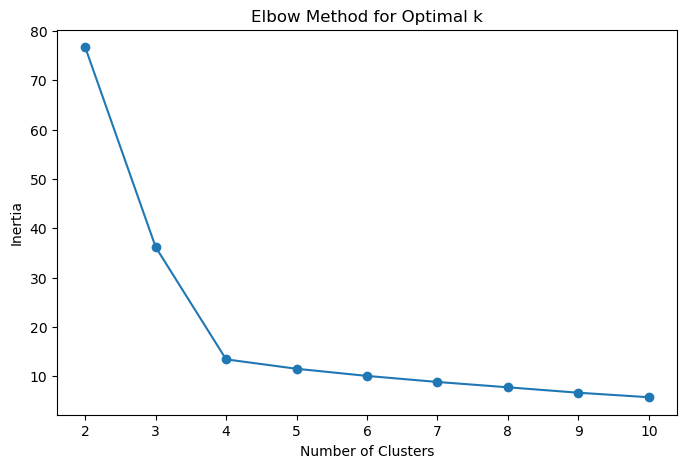

In [95]:
inertia = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(final_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

## Finding the Optimal Value of k Using the Elbow Method

To determine the optimal number of clusters (k) for the **KMeans** algorithm, we use the **elbow method**. This technique helps identify the point where increasing the number of clusters no longer significantly improves the model’s performance.



In [96]:
optimal_k = 4 
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
data['Cluster'] = kmeans.fit_predict(final_data)

## Evaluating the Clustering Performance

To evaluate the quality of our clustering results, we use two common metrics: **Davies-Bouldin Index (DB Index)** and **Silhouette Score**.

In [97]:
db_index = davies_bouldin_score(final_data, data['Cluster'])
silhouette = silhouette_score(final_data, data['Cluster'])
print(f"DB Index: {db_index:.4f}")
print(f"Silhouette Score: {silhouette:.4f}")

DB Index: 0.4606
Silhouette Score: 0.7103


## Visualizing Customer Segments with PCA

To better understand and visualize the customer segments formed by the KMeans clustering, we apply **Principal Component Analysis (PCA)** for dimensionality reduction. PCA helps to project the data into fewer dimensions (in this case, 2) while retaining the most important features of the data.

### Steps:
1. **PCA**: We reduce the feature space of the data from multiple dimensions to 2 components using `PCA(n_components=2)`. This helps in visualizing the high-dimensional data in a 2D plot.
2. **Clustering Visualization**: After performing PCA, we plot the first and second principal components of the data points on a 2D scatter plot. Each point is colored according to the cluster assignment, making it easy to observe how the customer segments are distributed.

The scatter plot allows us to visually assess:
- The separation between the clusters.
- How well the clustering algorithm (KMeans with 4 clusters) performed.

### Plot:
The plot shows the two principal components of the data, with the points color-coded according to the cluster they belong to. This visualization can provide insights into how distinct or overlapping the customer segments are.



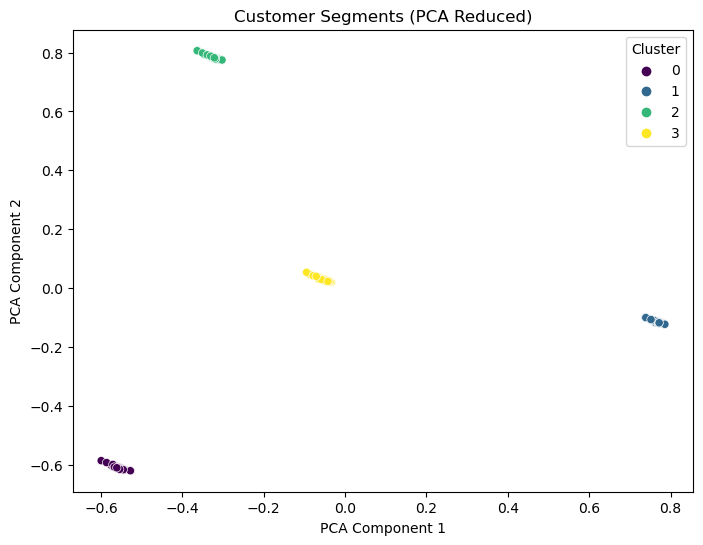

In [98]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(final_data)
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_data[:,0], y=pca_data[:,1], hue=data['Cluster'], palette='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Segments (PCA Reduced)')
plt.show()

## Visualizing Feature Correlations with a Heatmap

To understand the relationships between the features in our dataset, we use a **correlation matrix** and visualize it with a heatmap. The correlation matrix shows the pairwise correlation coefficients between all numeric features, indicating the strength and direction of their relationships.


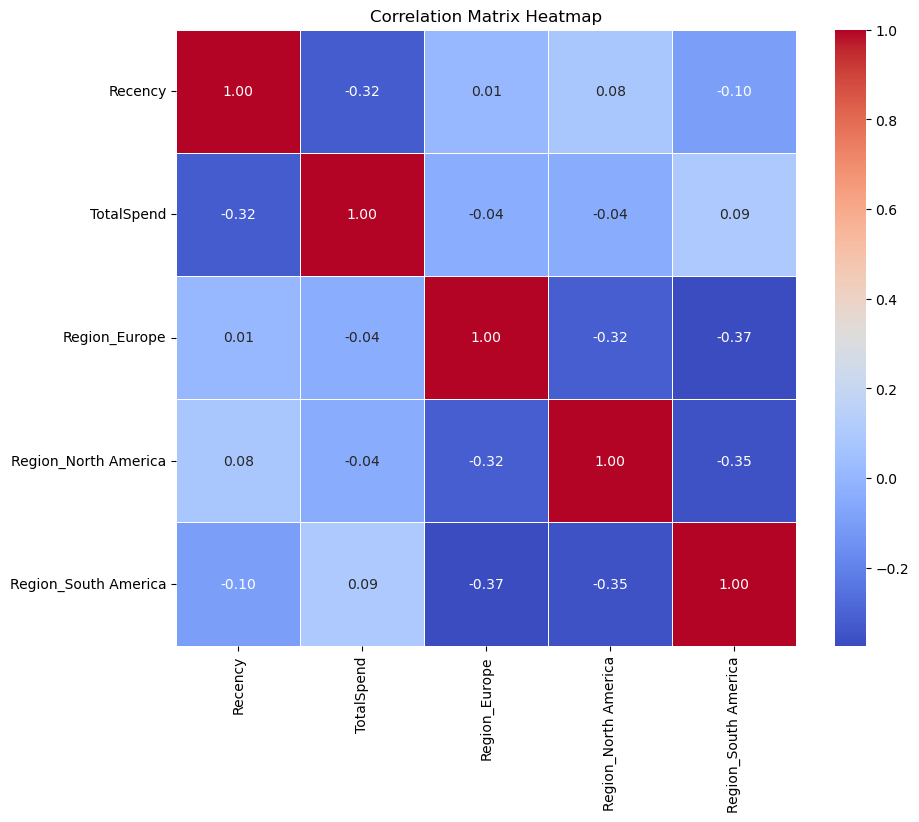

In [99]:
correlation_matrix = final_data.corr()


plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Correlation Matrix Heatmap')
plt.show()

## 3D Visualization of Customer Segments

To better understand the clustering results in a three-dimensional space, we create a **3D scatter plot**. This visualization allows us to see how customer segments are distributed across three features, providing a more comprehensive view of the clusters.


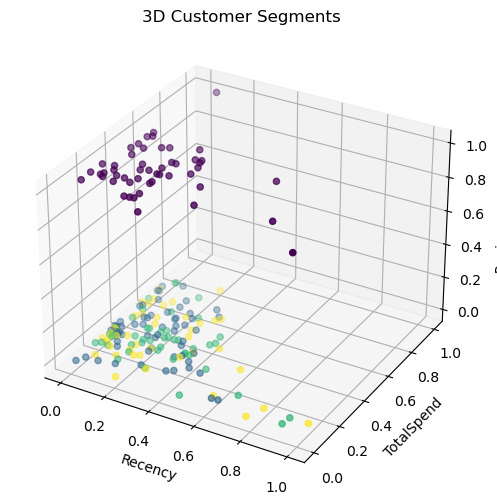

In [100]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(final_data.iloc[:,0], final_data.iloc[:,1], final_data.iloc[:,2], c=data['Cluster'], cmap='viridis')
ax.set_xlabel(final_data.columns[0])
ax.set_ylabel(final_data.columns[1])
ax.set_zlabel(final_data.columns[2])
plt.title("3D Customer Segments")
plt.show()
